In [60]:
!pip install sidrapy pmdarima

   ---------------------------------------- 0.0/614.7 kB ? eta -:--:--
    --------------------------------------- 10.2/614.7 kB ? eta -:--:--
   --- ----------------------------------- 61.4/614.7 kB 656.4 kB/s eta 0:00:01
   ------------------ --------------------- 286.7/614.7 kB 2.2 MB/s eta 0:00:01
   ---------------------------------------  614.4/614.7 kB 3.5 MB/s eta 0:00:01
   ---------------------------------------- 614.7/614.7 kB 3.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.8 MB 17.7 MB/s eta 0:00:01
   -------- ------------------------------- 0.6/2.8 MB 7.1 MB/s eta 0:00:01
   ------------- -------------------------- 0.9/2.8 MB 7.2 MB/s eta 0:00:01
   ------------------- -------------------- 1.4/2.8 MB 8.6 MB/s eta 0:00:01
   ------------------------- -------------- 1.8/2.8 MB 8.0 MB/s eta 0:00:01
   ----------------------------- ---------- 2.1/2.8 MB 7.7 MB/s eta 0:00:01
   --------

In [76]:
import pandas as pd
import sidrapy as sidra
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pmdarima as pm
import plotnine as p9

In [35]:
from statsmodels.tsa.seasonal import STL

In [21]:
dados_brutos = sidra.get_table(table_code = "5932", 
                               territorial_level="1", 
                               ibge_territorial_code="all", 
                               variable="6562",
                               classifications={"11255": "90707"}, 
                               period = "all"
                               )
dados_brutos

,NC,NN,MC,MN,V,D1C,D1N,D2C,D2N,D3C,D3N,D4C,D4N
0,Nível Territorial (Código),Nível Territorial,Unidade de Medida (Código),Unidade de Medida,Valor,Brasil (Código),Brasil,Trimestre (Código),Trimestre,Variável (Código),Variável,Setores e subsetores (Código),Setores e subsetores
1,1,Brasil,2,%,2.5,1,Brasil,199601,1º trimestre 1996,6562,Taxa acumulada em quatro trimestres (em relaçã...,90707,PIB a preços de mercado
2,1,Brasil,2,%,2.1,1,Brasil,199602,2º trimestre 1996,6562,Taxa acumulada em quatro trimestres (em relaçã...,90707,PIB a preços de mercado
3,1,Brasil,2,%,2.3,1,Brasil,199603,3º trimestre 1996,6562,Taxa acumulada em quatro trimestres (em relaçã...,90707,PIB a preços de mercado
4,1,Brasil,2,%,2.2,1,Brasil,199604,4º trimestre 1996,6562,Taxa acumulada em quatro trimestres (em relaçã...,90707,PIB a preços de mercado
...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,1,Brasil,2,%,3.0,1,Brasil,202204,4º trimestre 2022,6562,Taxa acumulada em quatro trimestres (em relaçã...,90707,PIB a preços de mercado
109,1,Brasil,2,%,3.7,1,Brasil,202301,1º trimestre 2023,6562,Taxa acumulada em quatro trimestres (em relaçã...,90707,PIB a preços de mercado
110,1,Brasil,2,%,3.7,1,Brasil,202302,2º trimestre 2023,6562,Taxa acumulada em quatro trimestres (em relaçã...,90707,PIB a preços de mercado
111,1,Brasil,2,%,3.1,1,Brasil,202303,3º trimestre 2023,6562,Taxa acumulada em quatro trimestres (em relaçã...,90707,PIB a preços de mercado


# Tratamento de dados

In [52]:
dados_limpos = (
    dados_brutos
    .rename(columns = dados_brutos.iloc[0])
    .query("Valor != 'Valor'")
    .assign(
        data = lambda x: pd.to_datetime(
            x["Trimestre (Código)"].str.slice_replace(start = 4, stop=5, repl="-Q"), 
            utc =True)
    ,
    pib=lambda x: x["Valor"].astype(float) # importante deixar dados em Float
    )
    .filter(items = ["data", "pib"], axis = "columns")
    .set_index("data")
    .asfreq("QS")
)
dados_limpos

C:\Users\pedro\AppData\Local\Temp\ipykernel_19488\3396389133.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = lambda x: pd.to_datetime(


,pib
data,
1996-01-01 00:00:00+00:00,2.5
1996-04-01 00:00:00+00:00,2.1
1996-07-01 00:00:00+00:00,2.3
1996-10-01 00:00:00+00:00,2.2
1997-01-01 00:00:00+00:00,3.2
...,...
2022-10-01 00:00:00+00:00,3.0
2023-01-01 00:00:00+00:00,3.7
2023-04-01 00:00:00+00:00,3.7


# Análise Exploratória dos Dados

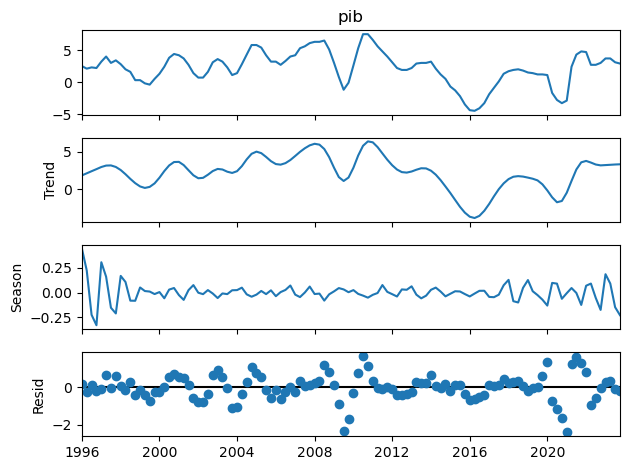

In [53]:
# Decomposição STL 
res = STL(dados_limpos.pib).fit()
res.plot()
plt.show()

# Gráfico Autocorrelação

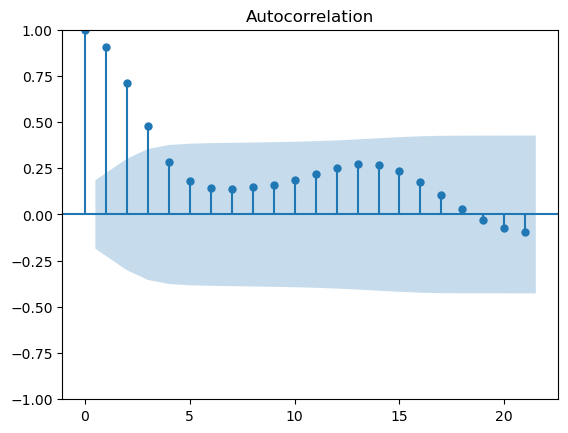

In [56]:
# Análise de autocorrelação
sm.graphics.tsa.plot_acf(dados_limpos.pib)
plt.show()

# Gráfico autocorrelação parcial 

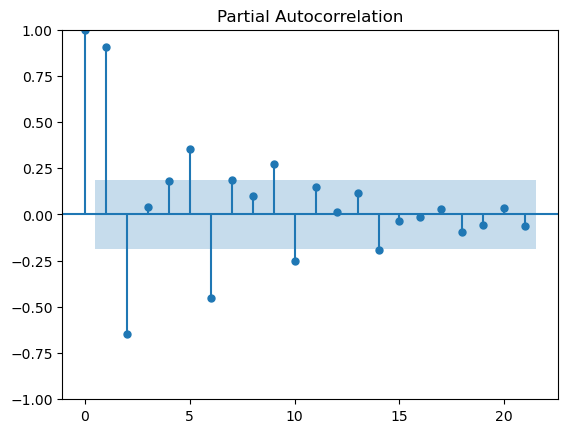

In [57]:
# Análise de autocorrelação
sm.graphics.tsa.plot_pacf(dados_limpos.pib)
plt.show()

# Modelos 

A função auto-ARIMA busca identificar os parâmetros mais adequados para um modelo ARIMA, resultando em um único modelo ARIMA ajustado.

In [80]:
# Estimar modelos
# p is the order (number of time lags) of the autoregressive model, 
# d is the degree of differencing 
# (the number of times the data have had past values subtracted)
# q is the order of the moving-average model

modelo_ar2 = pm.arima.ARIMA(order = (2, 0, 0)).fit(dados_limpos.pib)
modelo_ma4 = pm.arima.ARIMA(order = (0, 0, 4)).fit(dados_limpos.pib)
modelo_auto_arima = pm.arima.auto_arima(dados_limpos.pib, m = 4)

c:\Users\pedro\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
c:\Users\pedro\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


In [63]:
# Estimativas do modelo
modelo_ar2.summary()
modelo_ma4.summary()
modelo_auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  112
Model:             SARIMAX(2, 0, 2)x(2, 0, [1], 4)   Log Likelihood                 -92.665
Date:                             Sun, 02 Jun 2024   AIC                            203.330
Time:                                     17:44:58   BIC                            227.797
Sample:                                 01-01-1996   HQIC                           213.257
                                      - 10-01-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0241      0.021      1.159      0.246      -0.017       0.065
ar.L1          1.9191      0.079     24.358      0.000       1.765       2.073
ar.L2         -0.9250      0.080    -11.595      0.000      -1.081      -0.769
ma.L1         -0.1690      0.117     -1.447      0.148      -0.398       0.060
ma.L2         -0.2182      0.178     -1.225      0.220      -0.567       0.131
ar.S.L4       -0.4944      0.112     -4.411      0.000      -0.714      -0.275
ar.S.L8       -0.2085      0.141     -1.479      0.139      -0.485       0.068
ma.S.L4       -0.9511      0.199     -4.788      0.000      -1.340      -0.562
sigma2         0.2667      0.041      6.531      0.000       0.187       0.347
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):               187.27
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               2.02   Skew:                            -1.12
Prob(H) (two-sided):                  0.04   Kurtosis:                         8.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Avaliação Modelos

O melhor modelo será aquele que tem o critério de informação AIC com menor valor. Nesse caso o Auto Arima estimado foi o escolhido. 

In [65]:
# Critérios de informação
def ci(modelo, nome):
  return pd.Series(
      [modelo.aic(), modelo.aicc(), modelo.bic()],
      index = ["aic", "aicc", "bic"],
      name = nome
      )

pd.DataFrame(
    data = [ci(modelo_ar2, "ar2"), ci(modelo_ma4, "ma4"), ci(modelo_auto_arima, "auto_arima")]
    ).sort_values("aicc")

,aic,aicc,bic
auto_arima,203.330423,205.095129,227.796913
ma4,227.821053,228.621053,244.132046
ar2,282.829633,283.203465,293.703629


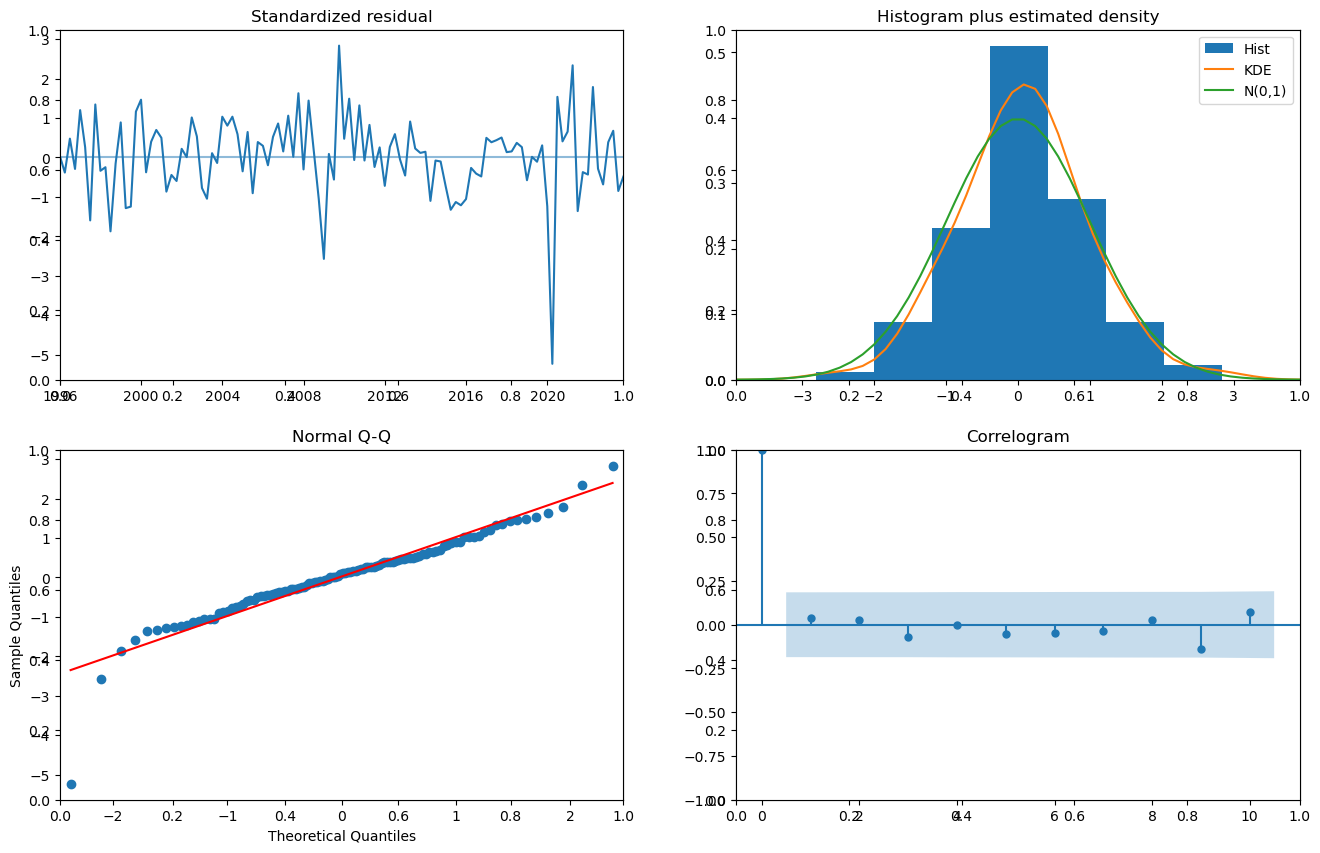

In [75]:
# Cria a figura com o tamanho desejado
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Chama a função de diagnóstico e passa a figura criada
modelo_auto_arima.plot_diagnostics(fig=fig)

# Exibe o gráfico
plt.show()

c:\Users\pedro\anaconda3\Lib\site-packages\plotnine\geoms\geom_path.py:100: PlotnineWarning: geom_path: Removed 15 rows containing missing values.
c:\Users\pedro\anaconda3\Lib\site-packages\plotnine\geoms\geom_path.py:100: PlotnineWarning: geom_path: Removed 112 rows containing missing values.


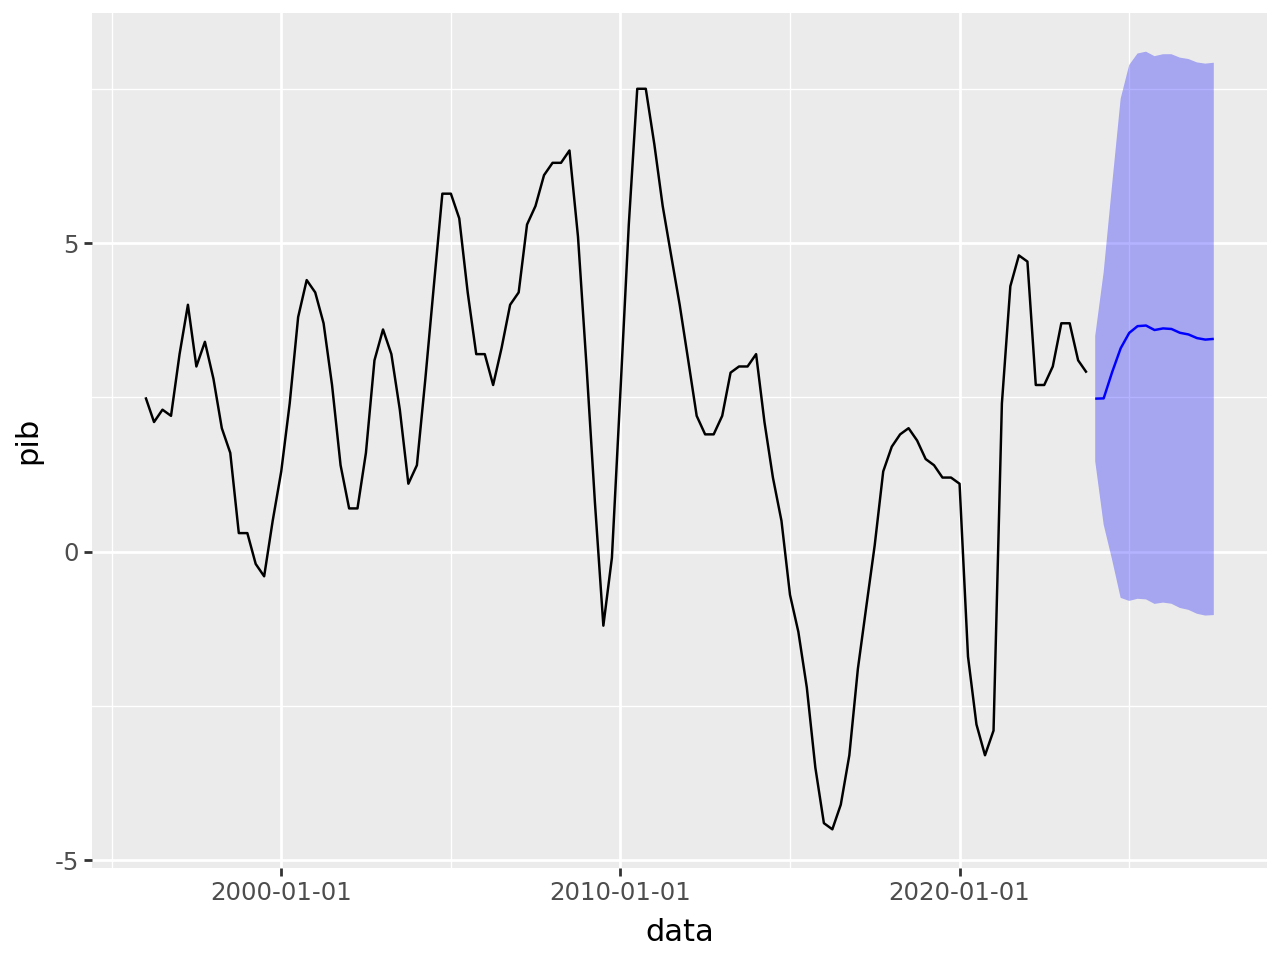

In [79]:
# Tabela de previsão
previsao = modelo_auto_arima.predict(n_periods = 15, return_conf_int = True)
previsao_pontual = pd.DataFrame(previsao[0], columns = ["Previsão"])
previsao_ic = pd.DataFrame(previsao[1], columns = ["Inf", "Sup"], index = previsao[0].index)
tabela_previsao = pd.concat(
    [dados_limpos, previsao_pontual.join(other = previsao_ic, how = "left")]
    ).assign(data = lambda x: x.index)

# Visualização de dados
(
    p9.ggplot(tabela_previsao) +
    p9.aes(x = "data") +
    p9.geom_line(p9.aes(y = "pib")) +
    p9.geom_line(p9.aes(y = "Previsão"), color = "blue") +
    p9.geom_ribbon(p9.aes(ymin = "Inf", ymax = "Sup"), fill = "blue", alpha = 0.3)
)